# dgesvd & dgemm scaling analysis

## Setup

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
pd.set_option("display.max_rows", 16)

## Reading data

In [4]:
data = pd.read_excel('svd_benchmarks.xlsx', sheetname='scaling')
data

,cluster,size,nodes,threads,HFD5 read (s),dgesvd (s),dgemm 1 & 2 (s),dgesvd efficiency,dgemm efficiency
0,thinking,1000000,1,1,0.035760,1.0600,0.15690,1.000000,1.000000
1,thinking,1000000,1,2,0.008324,0.6931,0.08490,0.764680,0.924028
2,thinking,1000000,1,4,0.008809,0.5592,0.04438,0.473891,0.883844
3,thinking,1000000,1,8,0.008725,0.5016,0.02702,0.264155,0.725851
4,thinking,1000000,1,10,0.009160,0.4786,0.02243,0.221479,0.699510
5,thinking,1000000,1,16,0.008274,0.4590,0.01920,0.144336,0.510742
6,thinking,1000000,1,20,0.008693,0.7924,0.02680,0.066885,0.292724
7,thinking,4000000,1,1,0.324400,7.6620,2.17500,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
69,cerebro,16000000,1,20,0.468000,26.5500,1.55200,0.156083,0.430735


In [5]:
data.columns

Index(['cluster', 'size', 'nodes', 'threads', 'HFD5 read (s)', 'dgesvd (s)',
       'dgemm 1 & 2 (s)', 'dgesvd efficiency', 'dgemm efficiency'],
      dtype='object')

## dgesvd efficiency for thinking

The parallel efficiency is defined as $E(n) = \frac{time(1)}{n \cdot time(n)}$, where $n$ represents the number of threads or processes.

In [6]:
thinking_svd = data[data['cluster'] == 'thinking'][['size', 'threads', 'dgesvd efficiency']].pivot_table(index='threads', columns=['size'])
thinking_svd

dgesvd efficiency                                        
size            1000000   4000000   16000000  64000000  256000000
threads                                                          
1                1.000000  1.000000  1.000000  1.000000  1.000000
2                0.764680  0.804325  0.864854  0.850775  0.847538
4                0.473891  0.632805  0.723230  0.753864  0.771552
8                0.264155  0.351468  0.461214  0.517282  0.552742
10               0.221479  0.329690  0.409448  0.437542  0.472495
16               0.144336  0.212079  0.272126  0.295027  0.319752
20               0.066885  0.130840  0.221433  0.236233  0.261451

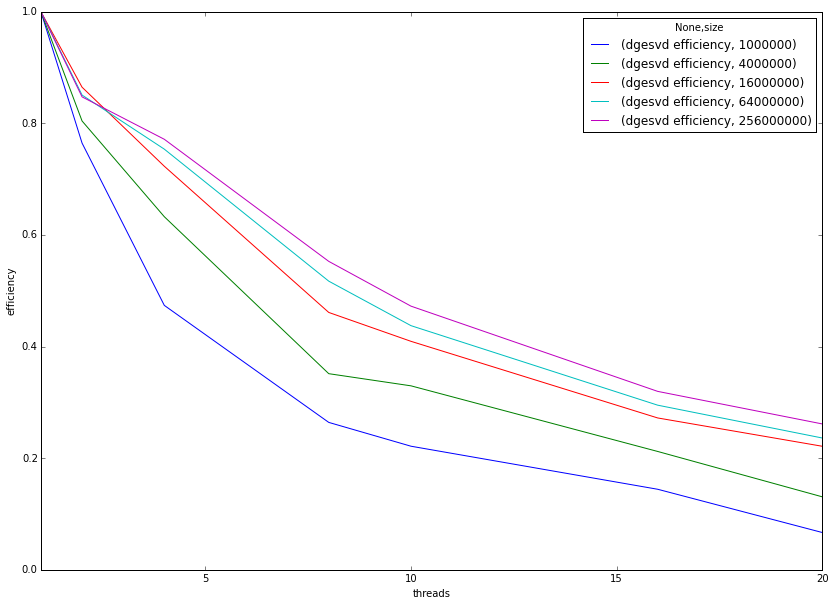

In [36]:
axes = thinking_svd.plot(figsize=(14, 10)); axes.set_ylim(0.0, 1.0); axes.set_ylabel('efficiency');

## dgemm efficiency for thinking

In [8]:
thinking_dgemm = data[data['cluster'] == 'thinking'][['size', 'threads', 'dgemm efficiency']].pivot_table(index='threads', columns=['size'])
thinking_dgemm

dgemm efficiency                                        
size           1000000   4000000   16000000  64000000  256000000
threads                                                         
1               1.000000  1.000000  1.000000  1.000000  1.000000
2               0.924028  0.687421  0.852522  0.969508  0.988084
4               0.883844  1.031980  0.845172  0.911588  0.955938
8               0.725851  0.269985  0.656049  0.848103  0.896581
10              0.699510  0.444331  0.581495  0.790492  0.859435
16              0.510742  0.317314  0.448244  0.779353  0.839761
20              0.292724  0.117238  0.617769  0.705833  0.814890

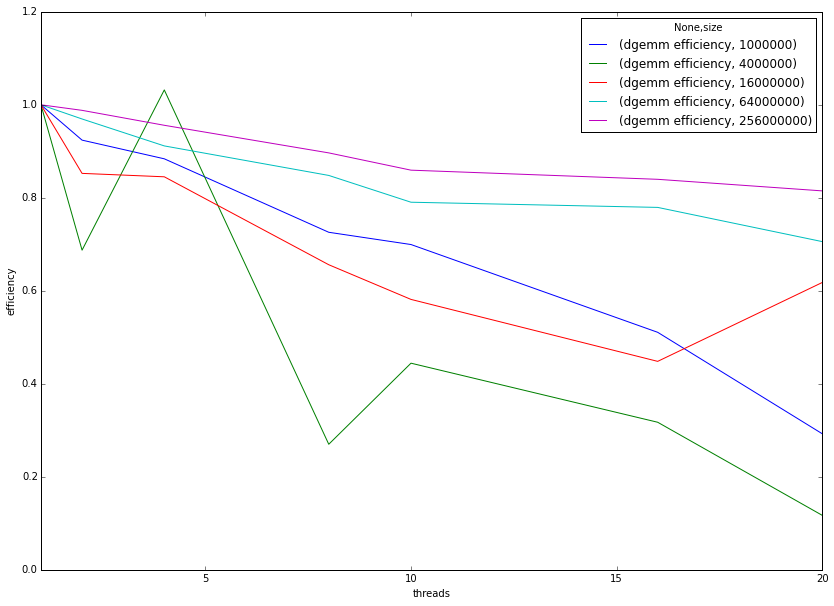

In [35]:
axes = thinking_dgemm.plot(figsize=(14, 10)); axes.set_ylim(0.0, 1.2); axes.set_ylabel('efficiency');

## dgesvd scaling on thinking

Determine the scaling properties of the SVD implementation on thinking, i.e., what is the runtime as a function of the matrix size when running with a single thread.

In [10]:
dgesvd_thinking = data[((data['cluster'] == 'thinking') & (data['threads'] == 1))][['size', 'dgesvd (s)']]

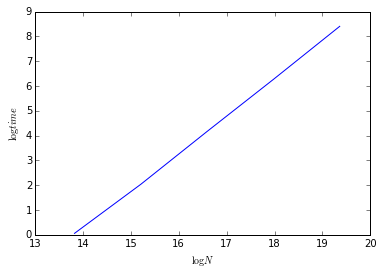

In [61]:
fig = plt.figure()
axes = fig.add_subplot('111')
axes.plot(np.log(dgesvd_thinking['size']), np.log(dgesvd_thinking['dgesvd (s)']))
axes.set_xlabel('$\log N$')
axes.set_ylabel('$\log time$')

In [12]:
slope, intercept, *_ = stats.linregress(np.log(np.sqrt(dgesvd_thinking['size'])), np.log(dgesvd_thinking['dgesvd (s)']))
slope, intercept

(3.0190605914108359, -20.85316351931348)

Hence, computing the SVD of a $2N \times 2N$ takes approximately $2^3$ times as long as that for an $N \times N$ matrix. This result is in excellent agreement with the theory.

## dgemm scaling on thinking

Due to bad scaling for small matrices fitting is done for $N \ge 8000$.

In [60]:
dgemm_thinking = data[((data['cluster'] == 'thinking') & (data['threads'] == 1))][['size', 'dgemm 1 & 2 (s)']]

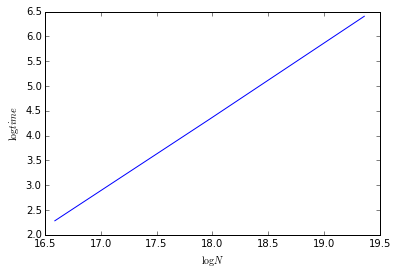

In [54]:
fig = plt.figure()
axes = fig.add_subplot('111')
axes.plot(np.log(dgemm_thinking['size'][2:]), np.log(dgemm_thinking['dgemm 1 & 2 (s)'][2:]))
axes.set_xlabel('$\log N$')
axes.set_ylabel('$\log time$')

In [44]:
slope, intercept, *_ = stats.linregress(np.log(np.sqrt(dgemm_thinking['size'][2:])),
                                        np.log(dgemm_thinking['dgemm 1 & 2 (s)'][2:]))
slope, intercept

(2.9740680283090408, -22.388829254703037)

For a matrix-matrix multiplication, the scaling is approximately the same as for SVD, i.e., $2^3$ in $N$, more than the theoretical optimum.

## dgesvd efficiency for cerebro

In [16]:
cerebro_svd = data[data['cluster'] == 'cerebro'][['size', 'threads', 'dgesvd efficiency']].pivot_table(index='threads', columns=['size'])
cerebro_svd

dgesvd efficiency                                              \
size           1000000    4000000    16000000   64000000   256000000    
threads                                                                 
1                1.000000   1.000000   1.000000   1.000000   1.000000   
2                0.857605   0.897682   0.940749   0.935974   0.852522   
4                0.601518   0.685935   0.769117   0.810888   0.845172   
8                0.299914   0.447359   0.522177   0.560050   0.656049   
10               0.236972   0.388386   0.446552   0.483538   0.581495   
16               0.124740   0.188562   0.225512   0.205586   0.448244   
20               0.112387   0.157975   0.156083   0.131837   0.617769   

                    
size    1024000000  
threads             
1         1.000000  
2         0.950379  
4         0.885284  
8         0.626292  
10        0.540733  
16        0.213778  
20        0.132627

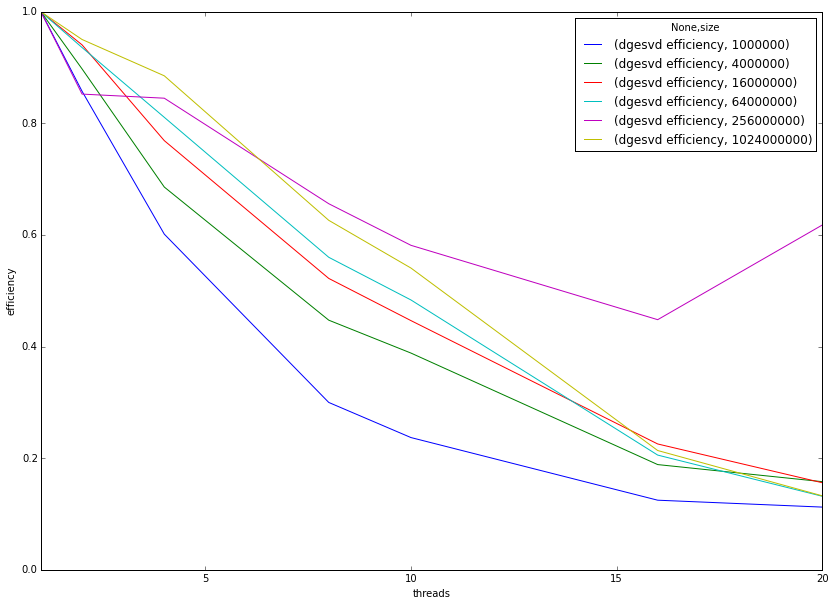

In [33]:
axes = cerebro_svd.plot(figsize=(14,10))
axes.set_ylim(0.0, 1.0)
axes.set_ylabel('efficiency');

## dgemm efficiency for cerebro

In [18]:
cerebro_dgemm = data[data['cluster'] == 'cerebro'][['size', 'threads', 'dgemm efficiency']].pivot_table(index='threads', columns=['size'])
cerebro_dgemm

dgemm efficiency                                              \
size          1000000    4000000    16000000   64000000   256000000    
threads                                                                
1               1.000000   1.000000   1.000000   1.000000   1.000000   
2               0.966024   0.875718   0.941152   0.981655   0.578132   
4               0.904868   1.165902   0.990370   0.961759   0.345671   
8               0.716817   0.527525   0.820044   0.954822   0.271024   
10              0.689610   0.243721   0.933008   0.912886   0.244231   
16              0.371364   0.407318   0.413881   0.793676   0.229673   
20              0.321319   0.224171   0.430735   0.610067   0.225801   

                    
size    1024000000  
threads             
1         1.000000  
2         0.997978  
4         0.995810  
8         0.992361  
10        0.987383  
16        0.957876  
20        0.874251

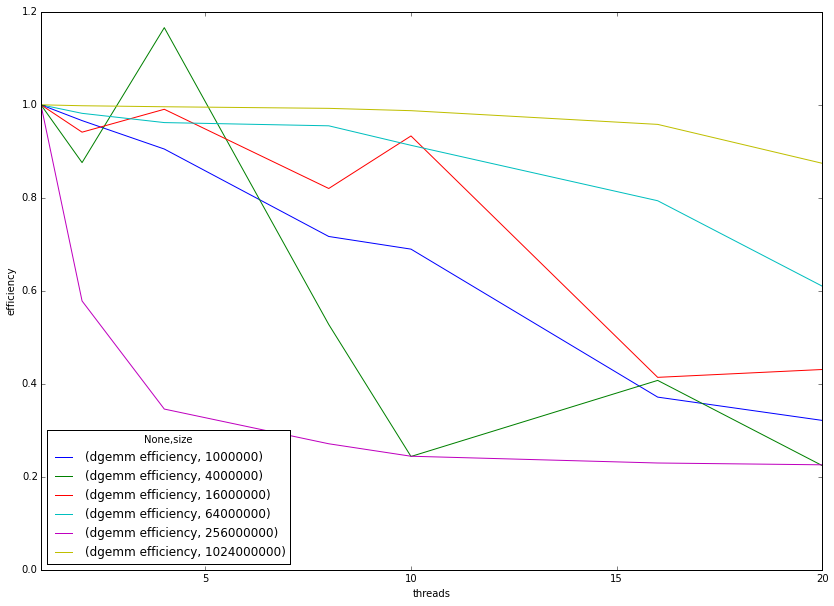

In [34]:
axes = cerebro_dgemm.plot(figsize=(14,10)); axes.set_ylim(0.0, 1.2)
axes.set_ylabel('efficiency');

(0.0, 1.2)

## dgesvd comparison

In [20]:
dgesvd_cmp = data[['threads', 'size', 'cluster', 'dgesvd (s)']].pivot_table(index='threads',
                                                                            columns=['size', 'cluster'])['dgesvd (s)']
dgesvd_cmp

size    1000000             4000000             16000000             \
cluster    cerebro thinking    cerebro thinking    cerebro thinking   
threads                                                               
1           1.5370   1.0600     10.300    7.662      82.88    64.57   
2           0.8961   0.6931      5.737    4.763      44.05    37.33   
4           0.6388   0.5592      3.754    3.027      26.94    22.32   
8           0.6406   0.5016      2.878    2.725      19.84    17.50   
10          0.6486   0.4786      2.652    2.324      18.56    15.77   
16          0.7701   0.4590      3.414    2.258      22.97    14.83   
20          0.6838   0.7924      3.260    2.928      26.55    14.58   

size    64000000            256000000           1024000000  
cluster    cerebro thinking    cerebro thinking    cerebro  
threads                                                     
1            628.6    526.8     5120.0   4475.0      42653  
2            335.8    309.6     2698.0   2640.0      22440  
4            193.8    174.7     1483.0   1450.0      12045  
8            140.3    127.3     1044.0   1012.0       8513  
10           130.0    120.4      967.5    947.1       7888  
16           191.1    111.6     1539.0    874.7      12470  
20           238.4    111.5     1948.0    855.8      16080

In [37]:
factors = pd.DataFrame()
for size in dgesvd_cmp.columns.levels[0]:
    try:
        factors[size] = dgesvd_cmp.loc[:, size].loc[:, 'cerebro']/dgesvd_cmp.loc[:, size].loc[:, 'thinking']
    except KeyError:
        pass

In [38]:
factors

,1000000,4000000,16000000,64000000,256000000
threads,,,,,
1,1.450000,1.344297,1.283568,1.193242,1.144134
2,1.292887,1.204493,1.180016,1.084625,1.021970
4,1.142346,1.240172,1.206989,1.109330,1.022759
8,1.277113,1.056147,1.133714,1.102121,1.031621
10,1.355203,1.141136,1.176918,1.079734,1.021539
16,1.677778,1.511957,1.548887,1.712366,1.759460
20,0.862948,1.113388,1.820988,2.138117,2.276233


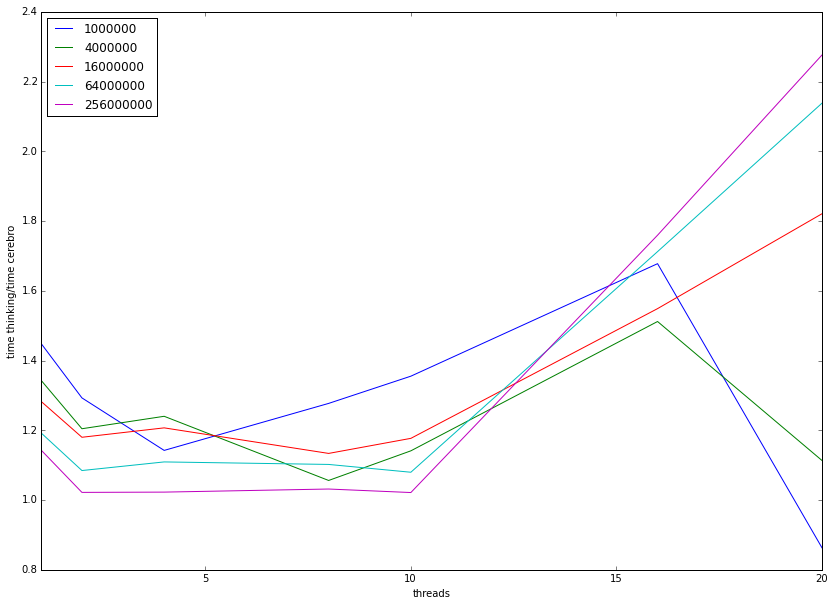

In [59]:
axes = factors.plot(figsize=(14, 10)); axes.set_ylabel('')
axes.set_ylabel('time thinking/time cerebro');